<a href="https://colab.research.google.com/github/caeliang/machine-learning/blob/main/MNIST_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
def load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500):
    x_data = []
    y_data = []

    x_folder = os.path.join(x_dir, class_label)
    y_folder = os.path.join(y_dir, class_label)

    for i, x_img_name in enumerate(os.listdir(x_folder)):
        if i >= max_samples:
            break

        x_img_path = os.path.join(x_folder, x_img_name)
        y_img_path = os.path.join(y_folder, x_img_name)

        x_img = tf.keras.preprocessing.image.load_img(x_img_path, color_mode='grayscale', target_size=(28, 28))
        y_img = tf.keras.preprocessing.image.load_img(y_img_path, color_mode='grayscale', target_size=(28, 28))

        x_img = tf.keras.preprocessing.image.img_to_array(x_img) / 255.0
        y_img = tf.keras.preprocessing.image.img_to_array(y_img) / 255.0

        x_data.append(x_img)
        y_data.append(y_img)

    return np.array(x_data), np.array(y_data)

x_dir = '/content/drive/MyDrive/mnist/x'
y_dir = '/content/drive/MyDrive/mnist/y'
x_data, y_data = load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500)

In [ ]:
latent_dim = 16  # Daha küçük latent boyut

# Encoder
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling Layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 32, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# CVAE Model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")

cvae_outputs = decoder(encoder(encoder_inputs)[2])
cvae = tf.keras.Model(encoder_inputs, cvae_outputs, name="cvae")

In [ ]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [ ]:
# CVAE Model
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return reconstructed

# Modeli oluştur
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer='adam')

In [ ]:
history = cvae.fit(x_data, y_data, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_1/kernel', 'dense_1/bias', 'conv2d_transpose/kernel', 'conv2d_transpose/bias', 'conv2d_transpose_1/kernel', 'conv2d_transpose_1/bias', 'conv2d_transpose_2/kernel', 'conv2d_transpose_2/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0277 - val_loss: 0.0022
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013 - val_loss: 6.0221e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.2850e-04 - val_loss: 1.6076e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3441e-04 - val_loss: 4.0853e-05
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.4942e-05 - val_loss: 3.6474e-05
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.9806e-05 - val_loss: 2.1512e-05
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0464e-05 - val_loss: 8.4910e-06
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.9956e-06 - val_loss: 4.1783e-06
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.7761e-06 - val_loss: 2.3180e-06
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9222e-06 - val_loss: 1.0580e-06


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


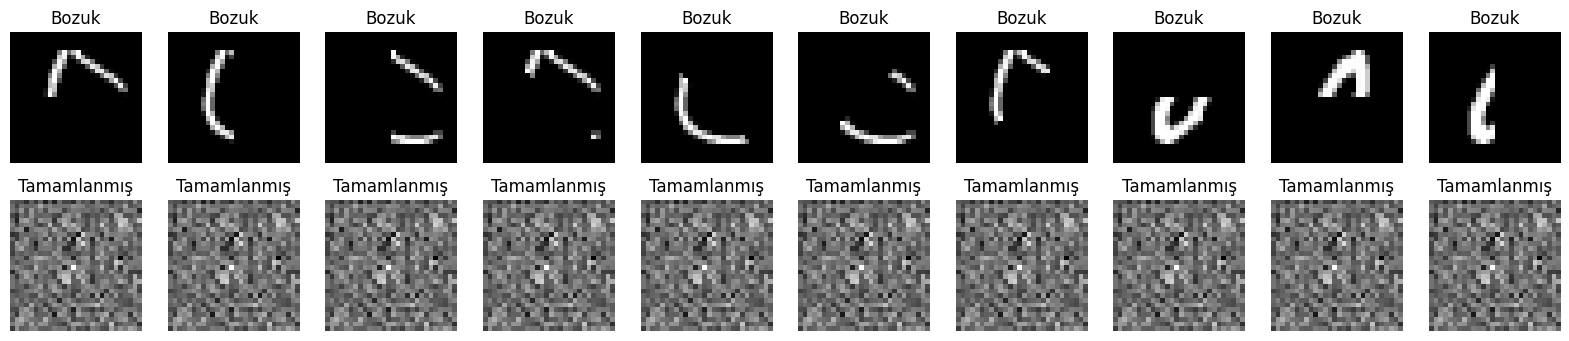

In [ ]:
def plot_results(models, data, batch_size=64):
    encoder, decoder = models
    x_test, y_test = data

    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    decoded_imgs = decoder.predict(z_mean)

    n = 10  # Görselleştirilecek örnek sayısı
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Bozuk Görseller
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Bozuk")
        plt.axis('off')

        # Tamamlanmış Görseller
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Tamamlanmış")
        plt.axis('off')
    plt.show()

plot_results((encoder, decoder), (x_data, y_data))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.2274 - val_loss: 0.2170
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2152 - val_loss: 0.2003
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.1935 - val_loss: 0.1713
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.1580 - val_loss: 0.1425
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.1258 - val_loss: 0.1353
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.1153 - val_loss: 0.1316
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1085 - val_loss: 0.1219
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0991 - val_loss: 0.1130
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0929 - val_loss: 0.1063
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0862 - val_loss: 0.1012
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


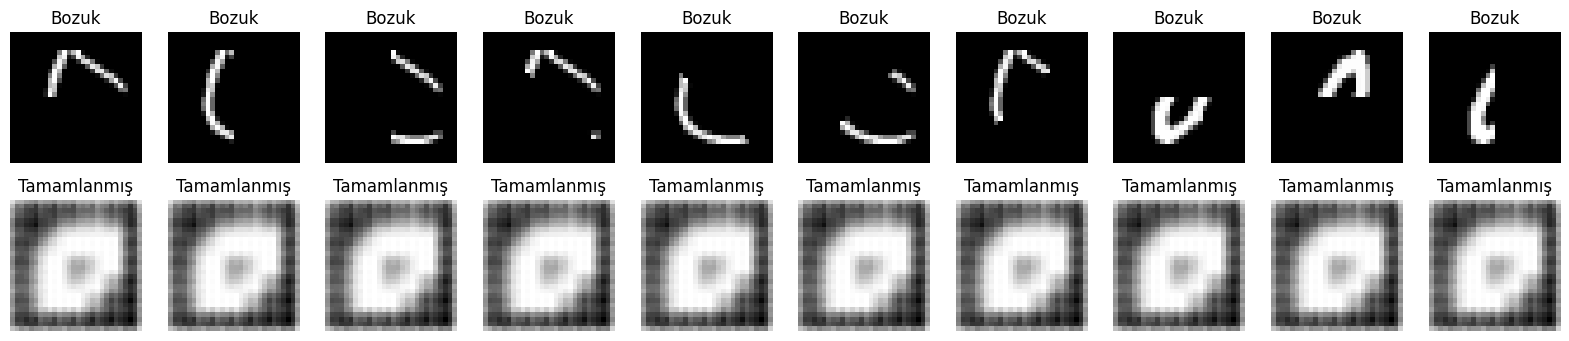

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500):
    x_data, y_data = [], []

    x_folder = os.path.join(x_dir, class_label)
    y_folder = os.path.join(y_dir, class_label)

    for i, x_img_name in enumerate(os.listdir(x_folder)):
        if i >= max_samples:
            break

        x_img_path = os.path.join(x_folder, x_img_name)
        y_img_path = os.path.join(y_folder, x_img_name)

        x_img = tf.keras.preprocessing.image.load_img(x_img_path, color_mode='grayscale', target_size=(28, 28))
        y_img = tf.keras.preprocessing.image.load_img(y_img_path, color_mode='grayscale', target_size=(28, 28))

        x_data.append(tf.keras.preprocessing.image.img_to_array(x_img) / 255.0)
        y_data.append(tf.keras.preprocessing.image.img_to_array(y_img) / 255.0)

    return np.array(x_data), np.array(y_data)

def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

def vae_loss(y_true, y_pred, z_mean, z_log_var):
    rec_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    return rec_loss + kl_loss(z_mean, z_log_var)

class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        self.add_loss(kl_loss(z_mean, z_log_var))
        return reconstructed

x_dir = '/content/drive/MyDrive/mnist/x'
y_dir = '/content/drive/MyDrive/mnist/y'
x_data, y_data = load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500)

cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.AdamW(), loss='mse')
cvae.fit(x_data, y_data, epochs=20, batch_size=64, validation_split=0.2)

def plot_results(encoder, decoder, x_test):
    z_mean, _, _ = encoder.predict(x_test)
    decoded_imgs = decoder.predict(z_mean)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Bozuk")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Tamamlanmış")
        plt.axis('off')
    plt.show()

plot_results(encoder, decoder, x_data)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0813 - val_loss: 0.0972
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0753 - val_loss: 0.0925
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0716 - val_loss: 0.0904
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0697 - val_loss: 0.0885
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0682 - val_loss: 0.0873
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0668 - val_loss: 0.0867
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0659 - val_loss: 0.0874
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0650 - val_loss: 0.0867
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0650 - val_loss: 0.0859
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0637 - val_loss: 0.0866
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0631 - val_loss: 0.0855
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0630 - val_loss: 0.0861


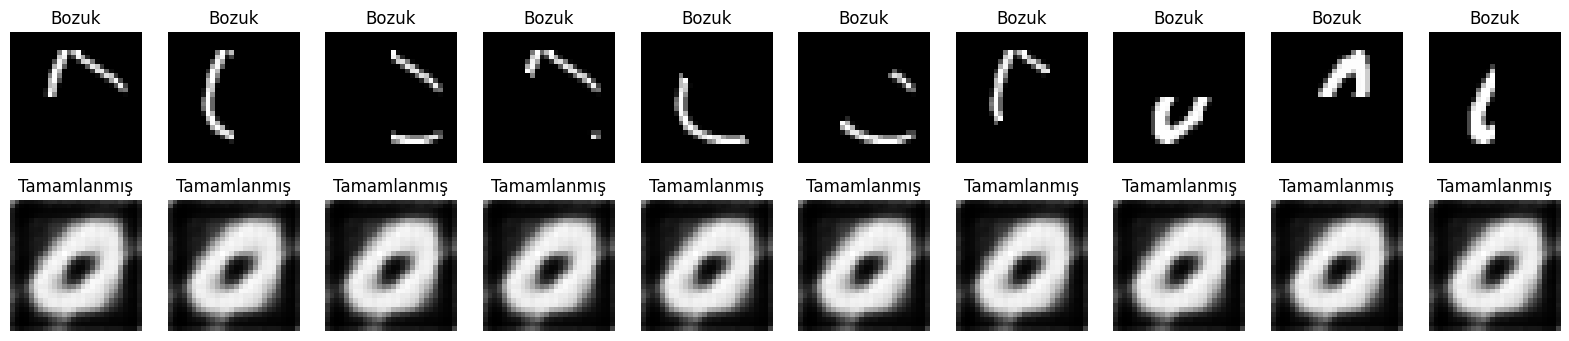

In [ ]:
cvae.compile(optimizer=tf.keras.optimizers.AdamW(), loss='mse')
cvae.fit(x_data, y_data, epochs=20, batch_size=64, validation_split=0.2)

def plot_results(encoder, decoder, x_test):
    z_mean, _, _ = encoder.predict(x_test)
    decoded_imgs = decoder.predict(z_mean)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Bozuk")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Tamamlanmış")
        plt.axis('off')
    plt.show()

plot_results(encoder, decoder, x_data)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - loss: 11.0159 - val_loss: 10.5380
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - loss: 10.4007 - val_loss: 9.9515
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - loss: 9.8209 - val_loss: 9.3952
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - loss: 9.2711 - val_loss: 8.8686
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 8.7510 - val_loss: 8.3714
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - loss: 8.2599 - val_loss: 7.9022
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - loss: 7.7965 - val_loss: 7.4599
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - loss: 7.3595 - val_loss: 7.0427
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 6.9468 - val_loss: 6.6491
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - loss: 6.5576 - val_loss: 6.2773
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 6.1884 - val_loss: 5.9263
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - loss: 5.8401 - val

<ipython-input-21-310a2f4005b7>:107: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_mean[:, 0], z_mean[:, 1], cmap='viridis')


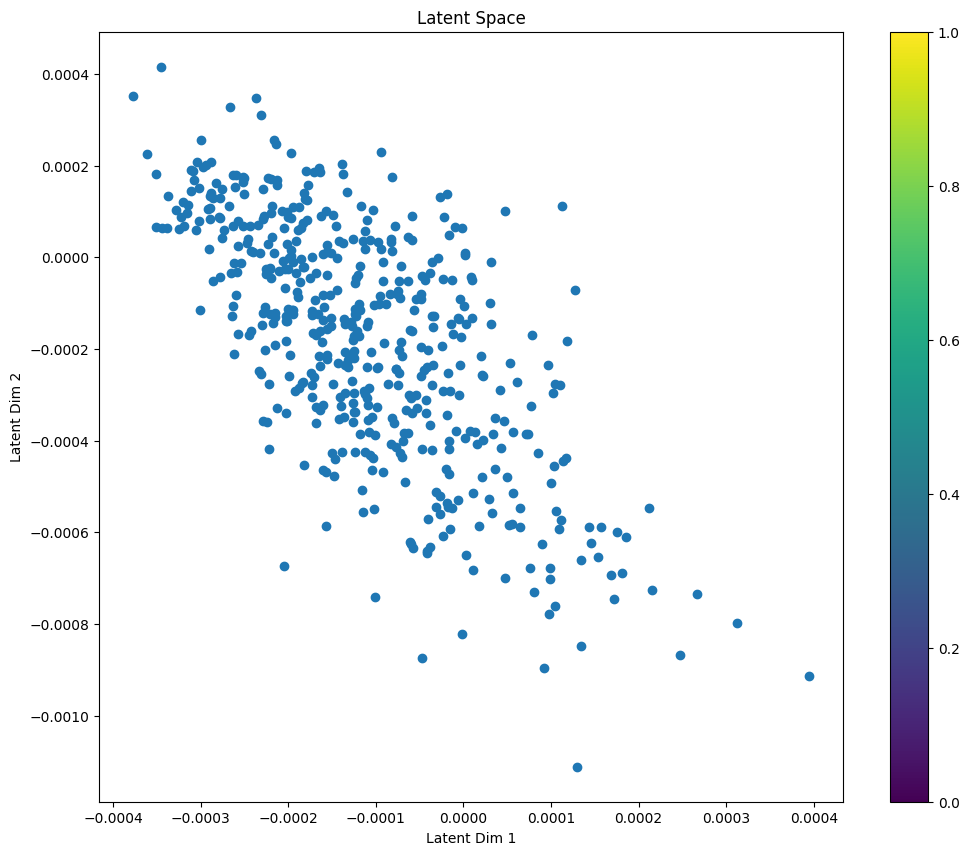

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


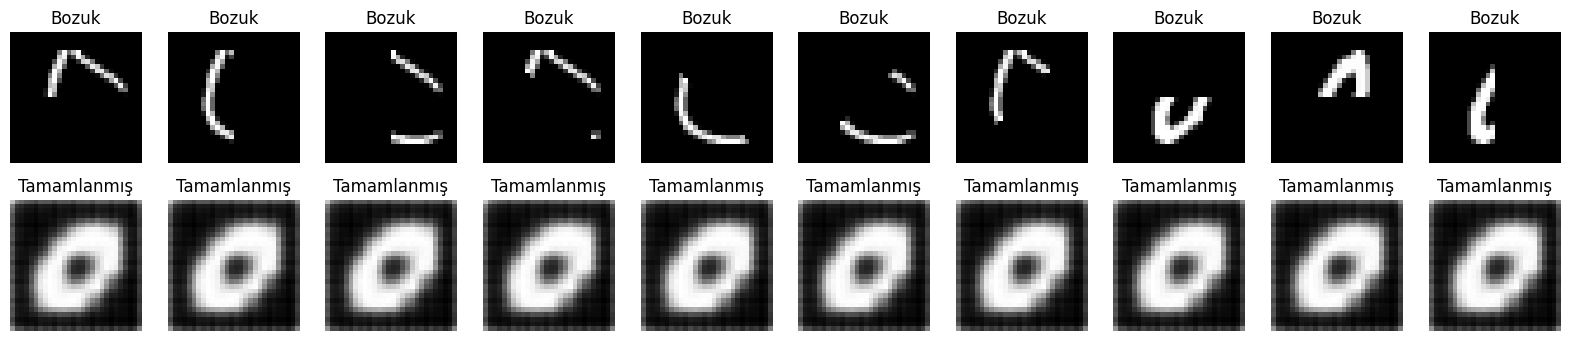

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Veriyi yükleme fonksiyonu
def load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500):
    x_data, y_data = [], []
    x_folder, y_folder = os.path.join(x_dir, class_label), os.path.join(y_dir, class_label)
    for i, x_img_name in enumerate(os.listdir(x_folder)):
        if i >= max_samples:
            break
        x_img_path, y_img_path = os.path.join(x_folder, x_img_name), os.path.join(y_folder, x_img_name)
        x_img = tf.keras.preprocessing.image.load_img(x_img_path, color_mode='grayscale', target_size=(28, 28))
        y_img = tf.keras.preprocessing.image.load_img(y_img_path, color_mode='grayscale', target_size=(28, 28))
        x_data.append(tf.keras.preprocessing.image.img_to_array(x_img) / 255.0)
        y_data.append(tf.keras.preprocessing.image.img_to_array(y_img) / 255.0)
    return np.array(x_data), np.array(y_data)

# Beta-VAE kaybı
def vae_loss(y_true, y_pred, z_mean, z_log_var, beta=4.0):
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    kl_loss = -0.5 * beta * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return recon_loss + kl_loss

# Encoder modeli
def build_encoder(latent_dim=128):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization ekleniyor
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization ekleniyor
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization ekleniyor
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])
    return tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')


def build_decoder(latent_dim=128):
    latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7 * 7 * 128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(latent_inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization ekleniyor
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization ekleniyor
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return tf.keras.Model(latent_inputs, outputs, name='decoder')

# CVAE Modeli
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder, self.decoder, self.beta = encoder, decoder, beta
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * self.beta * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return reconstructed

# Model oluştur
# Model oluştur
latent_dim = 128
e_encoder = build_encoder(latent_dim)
e_decoder = build_decoder(latent_dim)
cvae = CVAE(e_encoder, e_decoder, beta=1.0)  # Beta değerini düşür
cvae.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001), loss='binary_crossentropy')

# Veriyi yükleyip eğit
x_dir, y_dir = '/content/drive/MyDrive/mnist/x', '/content/drive/MyDrive/mnist/y'
x_data, y_data = load_single_class_data(x_dir, y_dir, class_label='0', max_samples=500)
cvae.fit(x_data, y_data, epochs=50, batch_size=64, validation_split=0.2)
# Sonuçları görselleştir
def plot_results(models, data, batch_size=64):
    encoder, decoder = models
    x_test, y_test = data
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    decoded_imgs = decoder.predict(z_mean)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Bozuk")
        plt.axis('off')
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Tamamlanmış")
        plt.axis('off')
    plt.show()

def plot_latent_space(encoder, data, batch_size=64):
    z_mean, _, _ = encoder.predict(data, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], cmap='viridis')
    plt.colorbar()
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.title("Latent Space")
    plt.show()

plot_latent_space(e_encoder, x_data)
plot_results((e_encoder, e_decoder), (x_data, y_data))

In [5]:
!git config --global user.name "caeliang"
!git config --global user.email "ranimjadid@gmail.com"
!git clone https://github.com/caeliang/machine-learning/tree/main/VAE

Cloning into 'VAE'...
fatal: repository 'https://github.com/caeliang/machine-learning/tree/main/VAE/' not found
